#  **Setting Environment**


## Install hmmlearn and modify, then restart

In [1]:
!pip install hmmlearn

     |████████████████████████████████| 378kB 5.6MB/s 


Open /usr/local/lib/python3.7/dist-packages/hmmlearn/base.py and comment line 724 and 728

Then, restart(重新啟動執行階段)

## Setting position

In [1]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks') #更改路徑

# **CNN feature extracttion steps**

## Import library 

In [3]:
import pickle
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.layers import TimeDistributed,Activation,Dense,Dropout,Input,LSTM,Bidirectional,Masking,Embedding,GaussianNoise,Flatten
from keras.layers import BatchNormalization, Conv1D, MaxPooling1D, ZeroPadding1D, InputLayer, Conv2D, MaxPooling2D
from keras.models import Model, model_from_json, load_model, Sequential
from sklearn.model_selection import train_test_split, cross_val_score
# Callback the history and h5 for model because colab may disconnect
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
import CTCModel
from keras.preprocessing import sequence
from keras import backend as K
from keras.layers.convolutional import Conv3D
from keras.layers.core import Lambda
from hmmlearn import hmm

## Load MFCC feature and divide them into training and testing data

In [4]:
print("Loading...")
X = np.load('X_train_LSTM_aug_278_40_13727.npy')
y_onehot = np.load('y_train_LSTM_aug_278_40_13727.npy')
print("Success!")

Loading...
Success!


In [5]:
print("Setting training and testing data...")

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.1, random_state=5566)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
print(X_train.shape,X_test.shape)
# print(X_train[0,0,0,0])
print("Done.")

Setting training and testing data...
(12354, 278, 40, 1) (1373, 278, 40, 1)
Done.


## Use cross validation : 10-folder

In [6]:
from sklearn.model_selection import KFold
kf = KFold(10,shuffle=False)
KF_train_index = []
KF_test_index = []
for train_index, test_index in kf.split(X_train):
    print('train_index', train_index, 'test_index', test_index)
    KF_train_index.append(train_index)
    KF_test_index.append(test_index)
    train_X, train_y = X_train[train_index], y_train[train_index]
    test_X, test_y = X_train[test_index], y_train[test_index]

train_index [ 1236  1237  1238 ... 12351 12352 12353] test_index [   0    1    2 ... 1233 1234 1235]
train_index [    0     1     2 ... 12351 12352 12353] test_index [1236 1237 1238 ... 2469 2470 2471]
train_index [    0     1     2 ... 12351 12352 12353] test_index [2472 2473 2474 ... 3705 3706 3707]
train_index [    0     1     2 ... 12351 12352 12353] test_index [3708 3709 3710 ... 4941 4942 4943]
train_index [    0     1     2 ... 12351 12352 12353] test_index [4944 4945 4946 ... 6176 6177 6178]
train_index [    0     1     2 ... 12351 12352 12353] test_index [6179 6180 6181 ... 7411 7412 7413]
train_index [    0     1     2 ... 12351 12352 12353] test_index [7414 7415 7416 ... 8646 8647 8648]
train_index [    0     1     2 ... 12351 12352 12353] test_index [8649 8650 8651 ... 9881 9882 9883]
train_index [    0     1     2 ... 12351 12352 12353] test_index [ 9884  9885  9886 ... 11116 11117 11118]
train_index [    0     1     2 ... 11116 11117 11118] test_index [11119 11120 11121 .

In [7]:
print(KF_train_index[0])
print(KF_test_index[0])

[ 1236  1237  1238 ... 12351 12352 12353]
[   0    1    2 ... 1233 1234 1235]


## Training

In [8]:
folder_name = "crossval_test"

In [9]:
from sklearn.model_selection import KFold
kf = KFold(10,shuffle=False)
i = 0
for train_index, test_index in kf.split(X_train):
    print("This is NO."+str(i)+" folder")
    print('train_index', train_index, 'test_index', test_index)
    train_X, train_y = X_train[train_index], y_train[train_index]
    test_X, test_y = X_train[test_index], y_train[test_index]
    print("Setting model's structure...")
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3),
                    activation='relu',
                    input_shape=(278,40,1),padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation='relu',
                    padding='same'))

    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64, kernel_size=(3, 3),
                    activation='relu',
                    padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(128, kernel_size=(3, 3),
                    activation='relu',
                    padding='same'))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(256, kernel_size=(3, 3),
                    activation='relu',
                    padding='same'))


    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))


    model.add(Lambda(lambda x: K.squeeze(x,2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu',name ='feature_dense1'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',name ='feature_dense2'))
    model.add(Dropout(0.5))
    model.add(Dense(7,activation='softmax'))

    # model.summary()

    print("Compile...")

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    filepath="HMM/"+ folder_name +"/"+str(i)+"th/weights-improvement-{epoch:02d}-{val_accuracy:.3f}.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
    mode='max')

    # csv_logger = CSVLogger('EMD_HMM_tmp_unit64/training.log', separator=',', append=False)
    callbacks_list = [checkpoint]

    print('Training...')
    history = model.fit(train_X, train_y,
          batch_size=128,
          epochs=100,
          callbacks=callbacks_list,
          validation_data=(test_X, test_y))
    # 儲存訓練過程中 的 loss and acc
    with open("HMM/"+ folder_name +"/"+str(i)+'th_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    model.save("HMM/"+ folder_name +"/" + 'ASR_CNN_'+ str(i) +'.h5')  # creates a HDF5 file 'model.h5'
    i= i + 1

This is NO.0 folder
train_index [ 1236  1237  1238 ... 12351 12352 12353] test_index [   0    1    2 ... 1233 1234 1235]
Setting model's structure...
Compile...
Training...
Epoch 1/100
87/87 [==============================] - 39s 97ms/step - loss: 1.9698 - accuracy: 0.1726 - val_loss: 1.9895 - val_accuracy: 0.1715

Epoch 00001: val_accuracy improved from -inf to 0.17152, saving model to HMM/crossval_test/0th/weights-improvement-01-0.172.h5
Epoch 2/100
87/87 [==============================] - 6s 73ms/step - loss: 1.7420 - accuracy: 0.3041 - val_loss: 1.7601 - val_accuracy: 0.2905

Epoch 00002: val_accuracy improved from 0.17152 to 0.29045, saving model to HMM/crossval_test/0th/weights-improvement-02-0.290.h5
Epoch 3/100
87/87 [==============================] - 6s 74ms/step - loss: 1.4698 - accuracy: 0.4388 - val_loss: 1.2076 - val_accuracy: 0.5558

Epoch 00003: val_accuracy improved from 0.29045 to 0.55583, saving model to HMM/crossval_test/0th/weights-improvement-03-0.556.h5
Epoch 4/10

## Drawing loss and accuracy 

Use loop to display the CNN models' loss and accuracy.

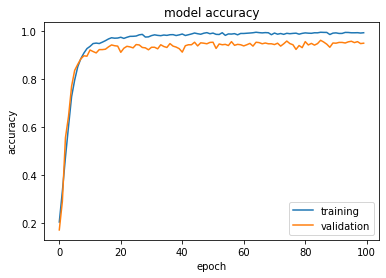

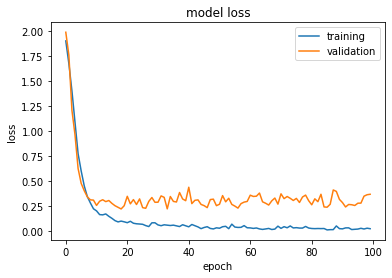

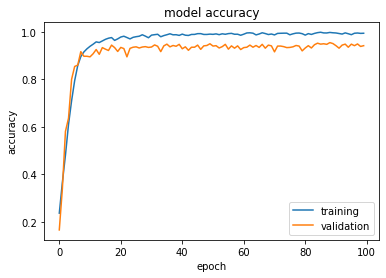

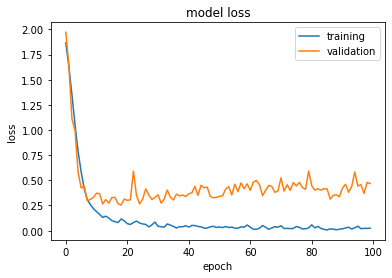

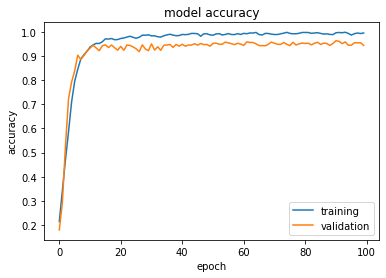

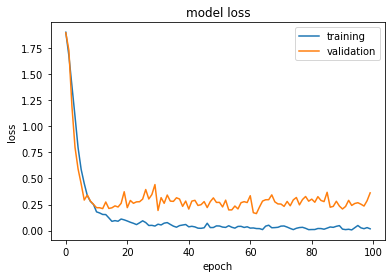

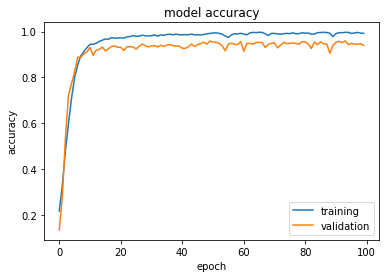

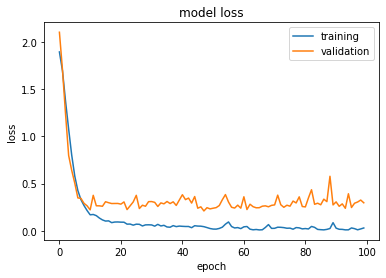

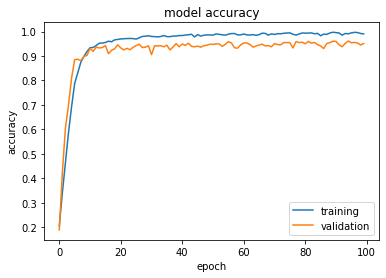

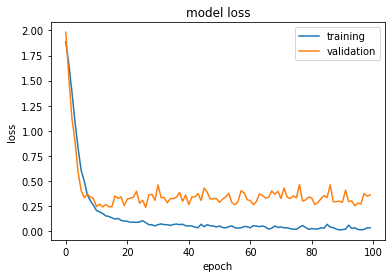

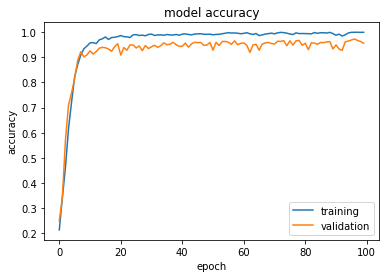

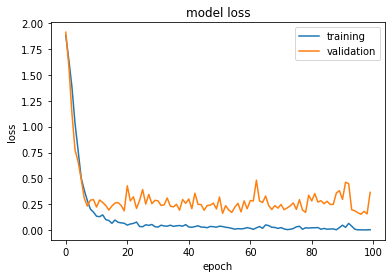

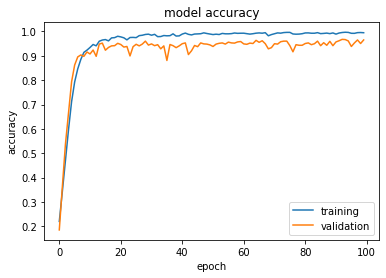

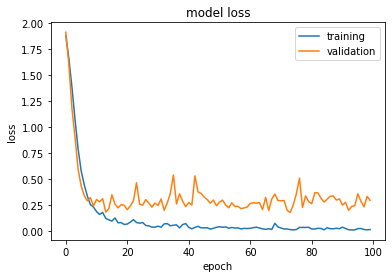

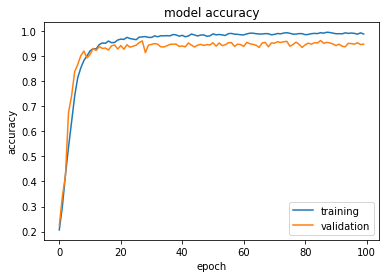

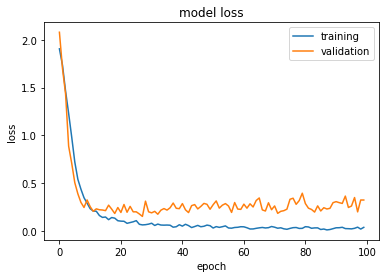

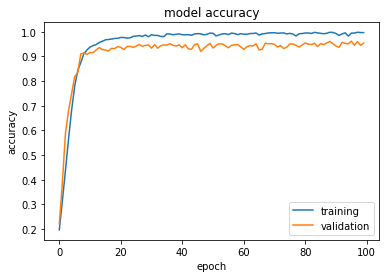

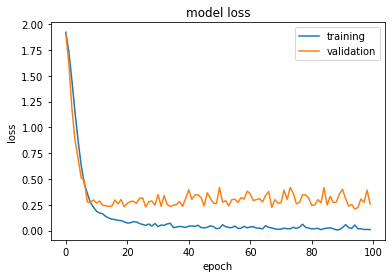

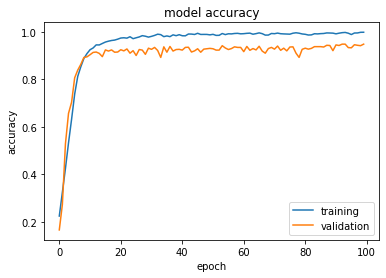

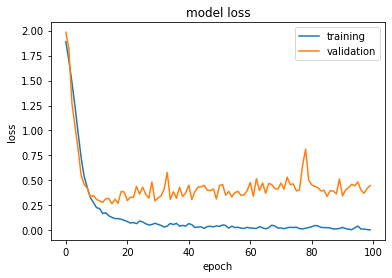

In [10]:
for j in range(10):
  with open("HMM/"+ folder_name +"/"+str(j)+"th_history", "rb") as file: 
    history_th = pickle.load(file)
    # summarize history for accuracy
    plt.plot(history_th['accuracy'])
    plt.plot(history_th['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    # summarize history for loss 
    plt.plot(history_th['loss']) 
    plt.plot(history_th['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

# **Training HMM using CNN features**

## Loading CNN model

In [9]:
def buildDataSet(X_train_features,y_train_features):
  dataset = {}
  for i, label in enumerate(y_train_features):
    if label not in dataset.keys():
        # print(label)
        dataset[label] = []
        dataset[label].append([X_train_features[i]])
    else:
        exist_feature = dataset[label]
        exist_feature.append([X_train_features[i]])
        dataset[label] = exist_feature
  return dataset

In [12]:
def train_HMM(dataset,states_num):
  HMM_Models = {}

  for label in dataset.keys():
      model = hmm.GaussianHMM(n_components=states_num,covariance_type='spherical', n_iter=100)
      trainData = dataset[label]
      length = np.zeros([len(trainData), ], dtype=np.int)
      for m in range(len(trainData)):
          length[m] = len(trainData[m])
      trainData = np.vstack(trainData)
      model.fit(trainData, lengths=length)  # get optimal parameters
      HMM_Models[label] = model
  return HMM_Models

第1個folder 0th  weights-improvement-86-0.962.h5


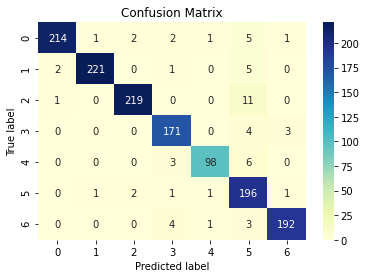

準確率： 95.4843408594319 %
第2個folder 1th  weights-improvement-89-0.955.h5


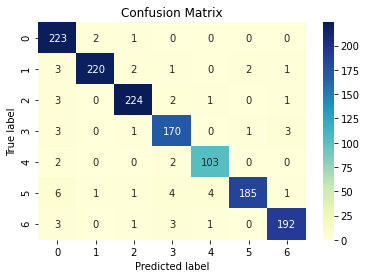

準確率： 95.92134013109978 %
第3個folder 2th  weights-improvement-91-0.963.h5


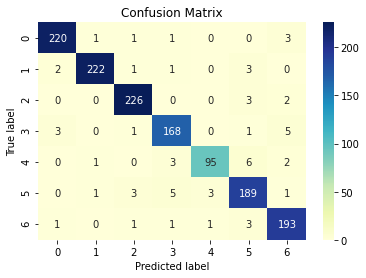

準確率： 95.63000728332119 %
第4個folder 3th  weights-improvement-94-0.960.h5


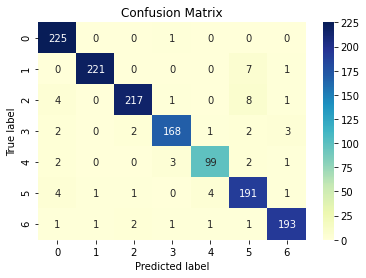

準確率： 95.70284049526585 %
第5個folder 4th  weights-improvement-95-0.961.h5


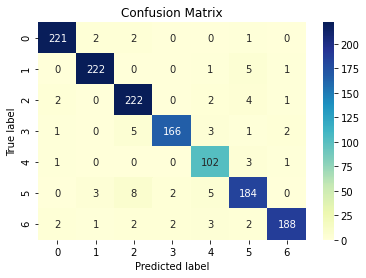

準確率： 95.04734158776402 %
第6個folder 5th  weights-improvement-97-0.972.h5


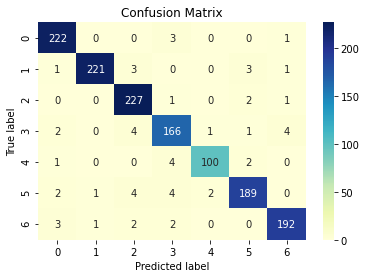

準確率： 95.92134013109978 %
第7個folder 6th  weights-improvement-93-0.968.h5


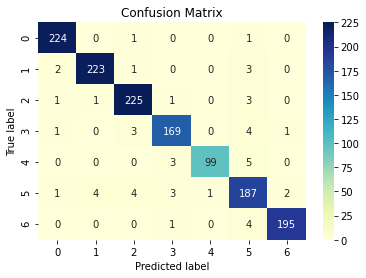

準確率： 96.28550619082301 %
第8個folder 7th  weights-improvement-86-0.964.h5


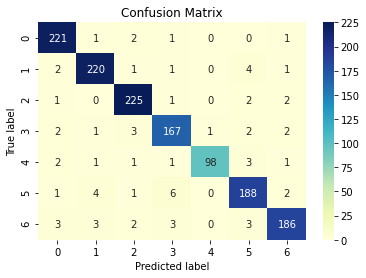

準確率： 95.04734158776402 %
第9個folder 8th  weights-improvement-96-0.962.h5


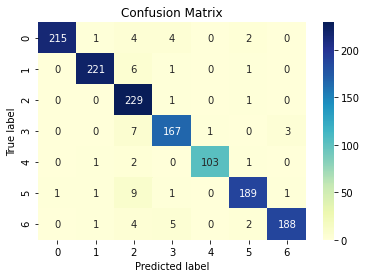

準確率： 95.55717407137655 %
第10個folder 9th  weights-improvement-93-0.948.h5


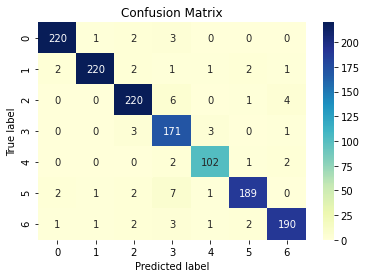

準確率： 95.55717407137655 %
平均準確率：95.61544064093225 %


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
score_list = []
states_num = 7

save_foldername = "test"
if not os.path.isdir("HMM/param_modify/"+save_foldername):
  os.mkdir("HMM/param_modify/"+save_foldername)

for i in range(10):
  file_list = os.listdir("HMM/"+ folder_name +"/"+str(i)+"th")
  file_list.sort(key=lambda filename: os.path.getmtime(os.path.join("HMM/"+ folder_name +"/"+str(i)+"th", filename)))
  print("第"+str(i+1)+"個folder "+str(i)+"th ",file_list[-1])
  # Load CNN model
  model = load_model('HMM/'+ folder_name + '/'+str(i)+"th/"+file_list[-1])
  # Get CNN features
  intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('feature_dense1').output)
  feauture_engg_data = intermediate_layer_model.predict(X_train[KF_train_index[i]])
  X_train_features = feauture_engg_data
  y_train_features = np.argmax(y_train[KF_train_index[i]], axis=-1)
  # Build training dataset
  Train_dataset = buildDataSet(X_train_features,y_train_features)
  # Train HMM models
  hmmModels = train_HMM(Train_dataset,states_num)

  # Save GHMM models.
  with open("HMM/param_modify/"+ save_foldername +"/GHMM_"+str(i)+"th.pkl", "wb") as file: 
    pickle.dump(hmmModels, file) 
  print("Finish training of the GHMM models")
  # Testing
  test_feauture = intermediate_layer_model.predict(X_test)
  test_label = np.argmax(y_test, axis=-1)
  testDataSet = buildDataSet(test_feauture,test_label)
  score_cnt = 0
  total_cnt = 0
  py = []
  predicts = []
  for label in testDataSet.keys():
      feature = testDataSet[label]
      for f in feature:
        scoreList = {}
        for model_label in hmmModels.keys():
            model = hmmModels[model_label]
            score = model.score(f)
            # print(score)
            scoreList[model_label] = score
        predict = max(scoreList, key=scoreList.get)
        # print("Test on true label ", label, ": predict result label is ", predict)
        py.append(label)
        predicts.append(predict)
        if predict == label:
            score_cnt+=1
        total_cnt+=1
  score_list.append(100.0*score_cnt/total_cnt)
  confusionMatrix = confusion_matrix(py,predicts)
  sns.heatmap(confusionMatrix,annot=True,fmt='.20g',cmap="YlGnBu")
  plt.title("Confusion Matrix")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  print("準確率：",100.0*score_cnt/total_cnt,"%")
print("平均準確率："+ str(np.mean(score_list)) +" %")